In [2]:
import os
os.environ['PATH'] += ":/content/mumax3.10"

In [29]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import Rbf

In [4]:
def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    from pandas import read_table
    
    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]
    
    return table

In [5]:
def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays 
    with the ovffilename (without extension) as key"""
    
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)
    
    return fields

In [6]:
def run_mumax3(script, name, verbose=False):
    """ Executes a mumax3 script and convert ovf files to numpy files
    
    Parameters
    ----------
      script:  string containing the mumax3 input script
      name:    name of the simulation (this will be the name of the script and output dir)
      verbose: print stdout of mumax3 when it is finished
    """
    
    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt" 
    outputdir  = name + ".out"

    # write the input script in scriptfile
    with open(scriptfile, 'w' ) as f:
        f.write(script)
    
    # call mumax3 to execute this script
    p = run(["mumax3","-f",scriptfile], stdout=PIPE, stderr=STDOUT)
    if verbose or p.returncode != 0:
        print(p.stdout.decode('UTF-8'))
        
    if path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None
        
    fields = read_mumax3_ovffiles(outputdir)
    
    return table, fields

In [7]:
script="""
T_final := 20e-9
fmax := 0.5e9

// Racetrack crystal settings:
length := 200e-9
width := 25e-9
delta := 100e-9
lattice_constant := 200e-9
N_unitcells := 8
Nx := 64
Ny := 512
Nz := 1
Lx := length
Ly := N_unitcells * lattice_constant
dX := length / Nx
dY := Ly / Ny
dZ := 1e-9 / Nz

setGridSize(Nx, Ny, Nz)
setCellSize(dX, dY, dZ)

// Material Constants
Bz := 0.05
Msat = 1250e3
Aex = 10e-12
anisU = vector(0, 0, 1)
Ku1 = 1.5e6
alpha = 0.1
Xi = 0.2
pinning := false

two_racetrack := rect(length, delta+width)
racetrack := rect(length, width)

gap := delta - width

singleR := racetrack.repeat(0, lattice_constant, 0).transl(0, width/2, 0)
twoR := singleR.add(singleR.transl(0, delta, 0))

setgeom(twoR)

// Define regions
defRegion(1, singleR)
defRegion(2, singleR.transl(0, delta, 0))
defRegion(3, racetrack.transl(0, -Ly/2+width/2, 0))
save(regions)

B_ext.setregion(3, vector(0, 0, Bz*sinc(2*pi*fmax*(t-T_final/2))))

m.setRegion(1, twoDomain(0, 0, 1, 1, 1, 0, 0, 0, -1))
m.setRegion(2, twoDomain(0, 0, -1, 1, 1, 0, 0, 0, 1))
m.setRegion(3, twoDomain(0, 0, 1, 1, 1, 0, 0, 0, -1))
relax()

// Schedule output & save results
autosave(m, 100e-12)
tableadd(e_total)
tableautosave(10e-12)

// Run for 1ns with current through the sample
temp.set(1)
j = vector(0, 0, 0)
pol = 1
run(T_final)
"""

In [8]:
table, fields = run_mumax3( script, name="DW_Lattice", verbose=False )

                 t        mx        my            mz       E_total
0     0.000000e+00  0.000058  0.053710 -3.539026e-08 -4.336963e-17
1     1.013081e-11  0.000220  0.053944  6.530434e-06 -4.316072e-17
2     2.032256e-11 -0.000492  0.053491 -3.940938e-05 -4.324261e-17
3     3.017442e-11  0.000078  0.053220 -1.554517e-05 -4.315339e-17
4     4.007447e-11  0.000208  0.053877 -7.374678e-06 -4.308781e-17
...            ...       ...       ...           ...           ...
1996  1.996006e-08  0.001857  0.047303  1.833903e-03 -4.305539e-17
1997  1.997014e-08  0.001778  0.046191  1.858743e-03 -4.304736e-17
1998  1.998011e-08  0.002637  0.046242  1.802212e-03 -4.315924e-17
1999  1.999003e-08  0.002396  0.047157  1.850562e-03 -4.295779e-17
2000  2.000000e-08  0.001460  0.046918  1.886700e-03 -4.301697e-17

[2001 rows x 5 columns]


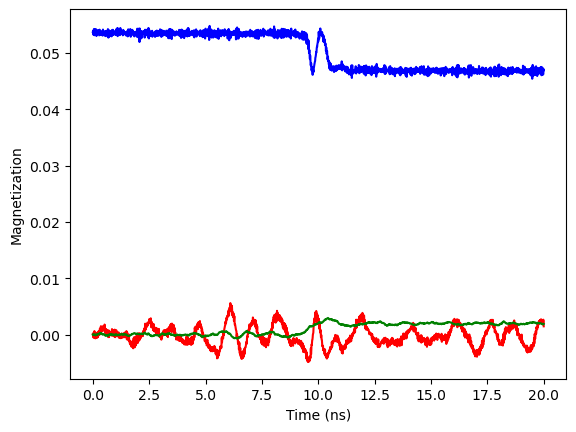

In [9]:
print(table)

plt.figure()

nanosecond = 1e-9
plt.plot( table["t"]/nanosecond, table["mx"], color='red')
plt.plot( table["t"]/nanosecond, table["my"], color='blue')
plt.plot( table["t"]/nanosecond, table["mz"], color='green')

plt.xlabel("Time (ns)")
plt.ylabel("Magnetization")

plt.show()

In [10]:
print(fields.keys())

dict_keys(['m000031', 'm000083', 'm000029', 'm000094', 'm000176', 'm000129', 'm000153', 'm000033', 'm000130', 'm000089', 'm000143', 'm000053', 'm000050', 'm000082', 'm000171', 'm000166', 'm000032', 'm000068', 'm000100', 'm000008', 'm000164', 'm000048', 'm000072', 'm000085', 'm000076', 'm000119', 'm000159', 'm000113', 'm000179', 'm000044', 'm000128', 'm000084', 'm000135', 'm000104', 'm000030', 'm000063', 'm000180', 'm000122', 'm000158', 'm000192', 'm000168', 'm000193', 'm000131', 'm000132', 'm000049', 'm000057', 'm000015', 'm000173', 'm000037', 'm000127', 'm000077', 'm000123', 'm000150', 'm000163', 'm000185', 'm000103', 'm000188', 'm000145', 'm000157', 'm000042', 'm000066', 'm000080', 'm000183', 'm000160', 'm000118', 'm000028', 'm000016', 'm000147', 'm000056', 'm000017', 'm000148', 'm000006', 'm000078', 'm000190', 'm000120', 'm000002', 'm000021', 'm000184', 'm000034', 'm000115', 'm000070', 'm000055', 'm000043', 'm000014', 'm000092', 'm000112', 'm000069', 'm000121', 'm000200', 'm000108',

In [15]:
# First field
# 4D numpy array: m[ic, iz, iy, ix]
# ic: index for the magnetization component (X=0, Y=1, Z=2)
m = fields["m000000"]

print("type  =", type(m))
print("shape =", m.shape)

type  = <class 'numpy.ndarray'>
shape = (3, 1, 512, 64)
(512, 64)


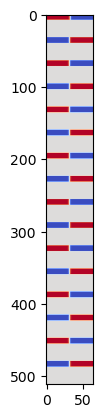

In [39]:
# intensity plot of the absolute value (mz)
def show_abs_my(m):
    my_abs = m[2,0,:,:]
    plt.figure()
    plt.imshow(my_abs, vmin=-1, vmax=1, cmap="coolwarm")
    plt.show()

show_abs_my(fields["m000199"])

In [40]:
'''
Return the value of DW position in a cell.
(By finding a point where mz == 0)
'''
def bisect(f, x_lo, x_hi, n):
    # midpoint
    x_o = (x_lo + x_hi) / 2.0
    # base case, run enough to converge.
    if n == 0:
        return x_o
    # base case, at x_o is 0
    if f(x_o) == 0:
        return x_o
    
    # ascending (-1 --> 1)
    if f(x_lo) < f(x_hi):
        if f(x_o) > 0:
            x_o = bisect(f, x_lo, x_o, n-1)
        else:
            x_o = bisect(f, x_o, x_hi, n-1)
    # descending (1 --> -1)
    else:
        if f(x_o) < 0:
            x_o = bisect(f, x_lo, x_o, n-1)
        else:
            x_o = bisect(f, x_o, x_hi, n-1)
    return x_o


In [49]:
# DW Positions in .ovf
print(findDW(fields["m000199"]))

[32.49365234375, 31.465087890625, 31.493896484375, 31.520263671875, 31.472412109375, 31.476318359375, 31.52685546875, 31.515380859375, 31.4970703125, 31.4833984375, 31.489990234375, 31.498291015625, 31.50732421875, 31.541015625, 31.52294921875, 31.5244140625]


TypeError: 'dict' object is not callable